## Objective
I will be trying to predict the tip amount as % of the total fare for NYC Yellow taxi cabs
## Data Used
Though the entire analysis can be replicated for any time period, I am using **January 2017** data for my analysis & modelling

Data Source: [Click Here](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-01.csv)

Data Dictionary: [Click Here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

## Evaluation
To evaluate different models, I would be using RMSE as the evaluation metric


## Step 1: Importing required libraries & modules

In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
!pip install -qq pycaret[full]

     |████████████████████████████████| 266kB 15.4MB/s 
     |████████████████████████████████| 102kB 7.8MB/s 
     |████████████████████████████████| 1.7MB 40.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 2.0MB 41.7MB/s 
     |████████████████████████████████| 215kB 44.7MB/s 
     |████████████████████████████████| 245kB 35.0MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 6.8MB 32.5MB/s 
     |████████████████████████████████| 276kB 41.4MB/s 
     |████████████████████████████████| 14.2MB 270kB/s 
     |████████████████████████████████| 3.6MB 30.9MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 166.7MB 77kB/s 
     |████████████████████████████████| 348kB 49.3MB

In [ ]:
from pycaret.utils import enable_colab
from pycaret.regression import *
enable_colab()

Colab mode enabled.


## Step 2: Ingesting data

* Added in the `parse_dates` argument to enable easy temporal feature extraction
* As the entire file has 9.7M rows, I am reading in the entire dataset and will randomly sample 200K entries from that to use as sample for analysis

In [ ]:
df_orig = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-01.csv', parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

## Step 3: EDA & Feature Engineering

In [ ]:
df_orig.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.5,0.0,0.5,2.00,0.0,0.3,15.30
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.0,0.0,0.5,1.45,0.0,0.3,7.25
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.5,0.0,0.5,1.00,0.0,0.3,7.30
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.0,0.0,0.5,1.70,0.0,0.3,8.50
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,52.0,0.0,0.5,0.00,0.0,0.3,52.80


In [ ]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9710124 entries, 0 to 9710123
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
dtypes: datetime64[ns](2), float64(8), int64(6), object(1)
memory usag

In [ ]:
df = df_orig.sample(n = 200000, random_state=42)

In [ ]:
df.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

There appear to be no null values, so we don't need to treat for that

In [ ]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,1.545720,1.630405,2.811535,1.040785,164.318985,161.725865,1.338635,12.241293,0.324057,0.497507,1.751416,0.272169,0.299706,15.390390
std,0.497907,1.274101,3.601994,0.567788,66.737326,70.684531,0.492354,10.735544,0.443326,0.037948,2.475229,1.345738,0.012725,13.229927
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-100.000000,-1.000000,-0.500000,-2.640000,0.000000,-0.300000,-100.300000
25%,1.000000,1.000000,0.940000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.300000
50%,2.000000,1.000000,1.600000,1.000000,162.000000,162.000000,1.000000,9.000000,0.000000,0.500000,1.290000,0.000000,0.300000,11.300000
75%,2.000000,2.000000,2.900000,1.000000,234.000000,234.000000,2.000000,13.500000,0.500000,0.500000,2.260000,0.000000,0.300000,16.640000
max,2.000000,9.000000,72.450000,99.000000,265.000000,265.000000,4.000000,440.000000,4.500000,0.500000,186.000000,95.540000,0.300000,440.300000


Few irregularities that are visible from above:


*   Minimum `passenger_count` is 0.  
*   Minimum `trip_distance` is 0.
*   Fare related fields like `fare_amount`, `mta_tax`, `extra`, etc. have negative values

Let's filter out these cases and re-check our data



In [ ]:
# Removing irregular values
df = df[(df['passenger_count'] > 0) & (df['trip_distance'] > 0) & (df['fare_amount'] > 0) & (df['extra'] >= 0) & (df['tolls_amount'] >= 0)]
# Removing any potential duplicate rows (Just for safety)
df.drop_duplicates(inplace = True)
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000,198677.000000
mean,1.546430,1.632071,2.828417,1.029928,164.256290,161.595232,1.335258,12.185643,0.324557,0.498621,1.741665,0.270650,0.299998,15.325382
std,0.497841,1.275649,3.601855,0.227271,66.679099,70.635925,0.487265,10.353775,0.440576,0.026223,2.341974,1.341584,0.000673,12.851108
min,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000
25%,1.000000,1.000000,0.960000,1.000000,114.000000,107.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.300000
50%,2.000000,1.000000,1.600000,1.000000,162.000000,162.000000,1.000000,9.000000,0.000000,0.500000,1.320000,0.000000,0.300000,11.300000
75%,2.000000,2.000000,2.920000,1.000000,234.000000,234.000000,2.000000,13.500000,0.500000,0.500000,2.260000,0.000000,0.300000,16.620000
max,2.000000,6.000000,72.450000,5.000000,265.000000,265.000000,4.000000,234.500000,4.500000,0.500000,73.750000,95.540000,0.300000,269.350000


### Adding target variable

In [ ]:
df['tip_perc'] = df['tip_amount'] / df['total_amount']

In [ ]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tip_perc
8267229,2,2017-01-27 21:00:32,2017-01-27 21:07:32,1,1.37,1,N,162,141,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96,0.166667
3408125,1,2017-01-03 22:05:39,2017-01-03 22:09:34,1,1.40,1,N,151,142,1,6.0,0.5,0.5,4.00,0.0,0.3,11.30,0.353982
5113601,1,2017-01-10 16:29:27,2017-01-10 16:40:28,1,1.00,1,N,170,186,2,8.0,1.0,0.5,0.00,0.0,0.3,9.80,0.000000
9502957,2,2017-01-31 11:45:49,2017-01-31 11:55:20,6,0.93,1,N,140,236,1,7.5,0.0,0.5,1.41,0.0,0.3,9.71,0.145211
7356107,1,2017-01-25 11:34:14,2017-01-25 11:39:22,1,0.70,1,N,170,161,2,5.0,0.0,0.5,0.00,0.0,0.3,5.80,0.000000


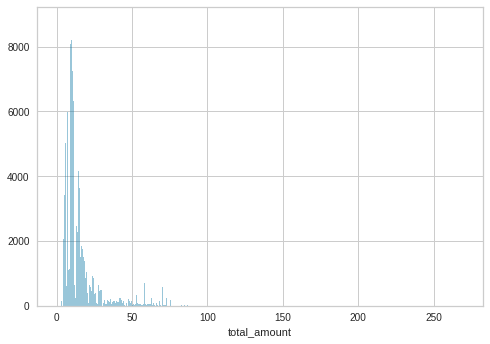

In [ ]:
# Checking distribution for total fare paid
sns.distplot(df['total_amount'],bins = 1000,kde = False)

These are definitely outliers in our data. We will treat them while setting up out PyCaret experiment

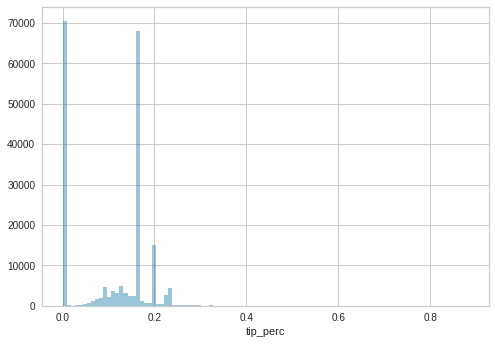

In [ ]:
# Checking the distribution for tip percentage
sns.distplot(df['tip_perc'], bins = 100, kde = False)

Looks like a multi-modal distribution with spikes on 0% and 20%. If we take care of the cases with no tip, the norm appears to be around 20% of fare.

In [ ]:
# Checking frequency counts for passenger counts
df['passenger_count'].value_counts()

1    142398
2     28465
5      9996
3      8171
6      5923
4      3724
Name: passenger_count, dtype: int64

I had tried other sample sizes and saw there are passenger counts more than 6 as well. However, everything above 6 can is very insignificant in volume and can be clubbed into 6

In [ ]:
df.loc[df.passenger_count >= 6,'passenger_count'] = 6

In [ ]:
df['payment_type'].value_counts()

1    133280
2     64422
3       739
4       236
Name: payment_type, dtype: int64

Since everything from 3 to 6 has no charge associated, we could club these into one. Let's also look at the distribution of tip_perc by each payment type.

In [ ]:
df.loc[df.payment_type >= 3, 'payment_type'] = 3

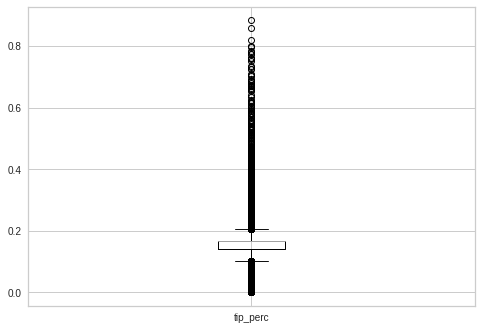

In [ ]:
df[df['payment_type'] == 1].boxplot(column = 'tip_perc')

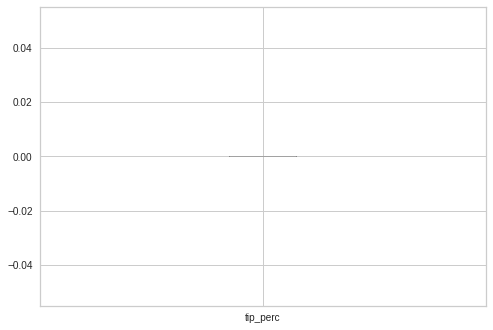

In [ ]:
df[df['payment_type'] == 2].boxplot(column = 'tip_perc')

### Concern
This highlights a major concern which was also highlighted in the data dictionary, i.e. Cash tips are not included in our tip_amount field. The implication is that 30% of our transactions where the payment mode is cash, do not have any tip value associated

### Potential Treatments
Option A - We forecast all cash trips to have '0' tip and maintain data the way it is
Option B - If we have to really predict tip_perc for real-world applications, I would filter the data for just credit card trips, train the model without `payment_type` feature, and use that model to predict tip_perc for any new data. However, using that technique here would not benefit us in model evaluation in theoritical context

#### Adding trip duration as a feature

In [ ]:
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1,'m')

#### Dropping tip amount from features
Need to drop otherwise other models might learn the relationship between tip amount and total amount that we defined


In [ ]:
df.drop('tip_amount',axis=1, inplace = True)

## Step 4: Environment Setup in PyCaret

Keeping 10% of the data away as unseen samples. Will use that as test set later

In [ ]:
data = df.sample(frac=0.9, random_state=42)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (178809, 18)
Unseen Data For Predictions (19868, 18)


In [ ]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'tip_perc', 'trip_duration'],
      dtype='object')

### Setting up the PyCaret experiment
Things considered and experimented with:

* Keeping 80% of the data for training and 20% for cross-validation
* Normalizing and transforming the numeric variables to scale and make them more gaussian like
* Transforming the target variable as well. Using `yeo-johnson` technique as target value has 0 values as well
* Binned certain numeric features like `Trip Duration`, `Trip Distance`, and `Total Amount`
* Using feature selection to reduce feature space. Removing low variance categorical features
* Added trigonometry features for temporal features
* Combining any rare levels in categorical features (Representing less than 5%)
* Removing any columns having >90% correlation
* Removing 2% of the extreme data as outliers

In [ ]:
exp_tip_pred1 = setup(data = data, target = 'tip_perc', session_id=121, train_size = 0.8,
                    normalize = True, transformation = True, transform_target = True, transform_target_method = 'yeo-johnson',
                    categorical_features = ['VendorID','RatecodeID','store_and_fwd_flag','PULocationID','DOLocationID','payment_type'],
                    numeric_features = ['passenger_count','trip_distance','fare_amount','extra','mta_tax', 'tolls_amount', 'improvement_surcharge', 'total_amount','trip_duration'],
                    bin_numeric_features = ['trip_duration','trip_distance','total_amount'],
                    feature_selection = True, feature_selection_threshold = 0.7, ignore_low_variance = True,
                    trigonometry_features = True,
                    combine_rare_levels = True, rare_level_threshold = 0.05,
                    remove_multicollinearity = True, multicollinearity_threshold = 0.9,
                    remove_outliers = True, outliers_threshold = 0.02,
                    log_experiment = True, experiment_name = 'tip_pred_1')

,Description,Value
0,session_id,121
1,Target,tip_perc
2,Original Data,"(178809, 18)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(140186, 322)"


In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Testing several commonly used models

In [ ]:
compare_models(fold = 5, include = ['lr','lasso','ridge','en','dt','rf','xgboost','lightgbm','catboost'], budget_time = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0146,0.0007,0.0259,0.9054,0.0226,0.2092,395.796
ridge,Ridge Regression,0.0232,0.0010,0.0316,0.8597,0.0284,0.2843,0.708
lr,Linear Regression,0.0234,0.0010,0.0316,0.8596,0.0284,0.2825,2.902
dt,Decision Tree Regressor,0.0172,0.0012,0.0339,0.8380,0.0297,0.2285,7.320
lasso,Lasso Regression,0.0766,0.0071,0.0843,-0.0002,0.0769,0.4817,0.588
en,Elastic Net,0.0766,0.0071,0.0843,-0.0002,0.0769,0.4817,0.580


PowerTransformedTargetRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='yeo-johnson',
                                p...
                                regressor=RandomForestRegressor(bootstrap=True,
                                                                ccp_alpha=0.0,
                                                                criterion='mse',
                                                                max_depth=None,
                      

Okay, so out of these Random Forest is giving the best results. Somehow, boosting models did not make it probably due to time limit. Let's try boosting and NN models without time-limit

In [ ]:
compare_models(fold = 5, include = ['xgboost','lightgbm','catboost', 'mlp'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.0149,0.0006,0.0250,0.9118,0.0220,0.2140,123.674
catboost,CatBoost Regressor,0.0153,0.0006,0.0251,0.9115,0.0220,0.2223,26.510
lightgbm,Light Gradient Boosting Machine,0.0146,0.0007,0.0258,0.9066,0.0225,0.2245,2.416
mlp,MLP Regressor,0.0201,0.0009,0.0297,0.8762,0.0261,0.2598,222.670


PowerTransformedTargetRegressor(base_score=None, booster='gbtree',
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, gamma=None, gpu_id=None,
                                importance_type='gain',
                                interaction_constraints=None,
                                learning_rate=None, max_delta_step=None,
                                max_depth=None, min_child_weight=None,
                                missing=nan, monotone_constraints=None,
                                n_estimators=100, n_jobs=-1,
                                nu...
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
                                                       n_jobs=-1,
                                                    

So the boosting models are performing better than others as expected. Let's create an xgboost model and use that for predictions.

In [ ]:
xgb = create_model('xgboost', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0150,0.0006,0.0250,0.9118,0.0220,0.1710
1,0.0148,0.0006,0.0253,0.9100,0.0221,0.1806
2,0.0146,0.0006,0.0244,0.9162,0.0214,0.2857
3,0.0150,0.0006,0.0254,0.9096,0.0222,0.2389
4,0.0149,0.0006,0.0251,0.9115,0.0221,0.1936
Mean,0.0149,0.0006,0.0250,0.9118,0.0220,0.2140
SD,0.0001,0.0000,0.0004,0.0023,0.0003,0.0428


## Step 5: Plotting results & Finalizing Model
Let's check the model params and plot residuals, errors, and feature importances

In [ ]:
plot_model(xgb, plot = 'parameter')

,Parameters
objective,reg:squarederror
base_score,None
booster,gbtree
colsample_bylevel,None
colsample_bynode,None
colsample_bytree,None
gamma,None
gpu_id,None
importance_type,gain
interaction_constraints,None


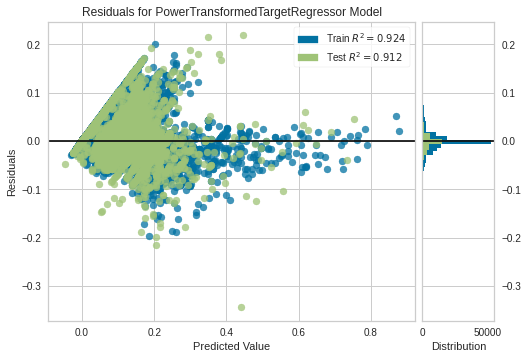

In [ ]:
plot_model(xgb)

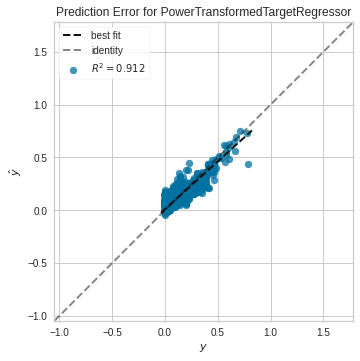

In [ ]:
plot_model(xgb, plot = 'error')

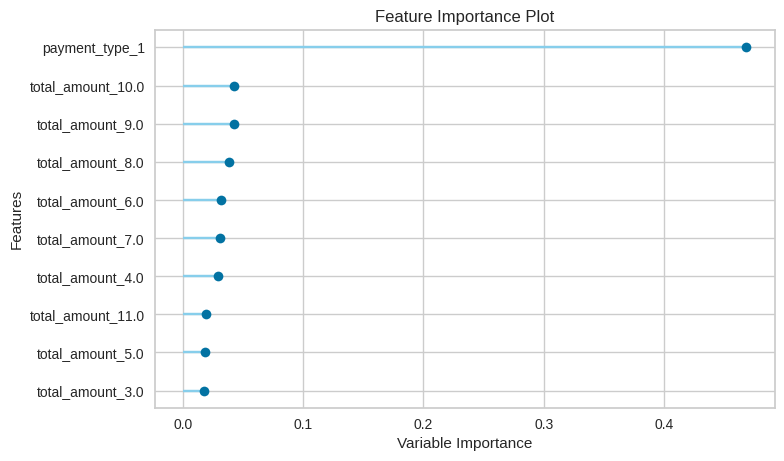

In [ ]:
plot_model(xgb, plot = 'feature')

Checking performance on the CV set

In [ ]:
predict_model(xgb)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0149,0.0006,0.025,0.9121,0.022,0.2068


,DOLocationID_10.0,payment_type_3,PULocationID_116.0,DOLocationID_92.0,tpep_dropoff_datetime_hour_12,tpep_dropoff_datetime_hour_0,PULocationID_49.0,PULocationID_113.0,DOLocationID_66.0,DOLocationID_195.0,DOLocationID_179.0,PULocationID_226.0,trip_duration_5.0,PULocationID_260.0,DOLocationID_181.0,PULocationID_164.0,PULocationID_244.0,DOLocationID_189.0,DOLocationID_211.0,tpep_pickup_datetime_hour_11,tpep_dropoff_datetime_hour_23,tpep_dropoff_datetime_hour_4,DOLocationID_246.0,PULocationID_255.0,PULocationID_48.0,DOLocationID_125.0,PULocationID_50.0,DOLocationID_138.0,tpep_dropoff_datetime_hour_15,tpep_pickup_datetime_hour_22,DOLocationID_74.0,tpep_dropoff_datetime_weekday_0,trip_duration_15.0,DOLocationID_225.0,tpep_dropoff_datetime_month_1,PULocationID_142.0,DOLocationID_140.0,PULocationID_87.0,PULocationID_25.0,DOLocationID_257.0,...,trip_distance_16.0,DOLocationID_25.0,PULocationID_132.0,trip_duration_1.0,tpep_pickup_datetime_hour_10,trip_duration_13.0,PULocationID_66.0,tpep_pickup_datetime_hour_16,DOLocationID_106.0,DOLocationID_151.0,total_amount_5.0,DOLocationID_146.0,PULocationID_148.0,DOLocationID_231.0,DOLocationID_166.0,tpep_dropoff_datetime_hour_21,trip_duration_10.0,tpep_pickup_datetime_hour_6,DOLocationID_163.0,PULocationID_230.0,DOLocationID_249.0,tpep_pickup_datetime_weekday_4,PULocationID_161.0,DOLocationID_65.0,tpep_dropoff_datetime_hour_22,DOLocationID_224.0,PULocationID_17.0,PULocationID_33.0,tpep_pickup_datetime_hour_4,total_amount_17.0,DOLocationID_226.0,tpep_pickup_datetime_hour_3,DOLocationID_145.0,PULocationID_236.0,total_amount_4.0,trip_distance_3.0,trip_distance_10.0,PULocationID_141.0,tip_perc,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.107527,0.108474
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165877,0.160294
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.004257
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000427
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204527,0.155

Finalize the model by using CV set for training as well

In [ ]:
final_xgb = finalize_model(xgb)

Checking performance for the finalized model

In [ ]:
predict_model(final_xgb)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0144,0.0006,0.0237,0.9207,0.0209,0.1996


,DOLocationID_10.0,payment_type_3,PULocationID_116.0,DOLocationID_92.0,tpep_dropoff_datetime_hour_12,tpep_dropoff_datetime_hour_0,PULocationID_49.0,PULocationID_113.0,DOLocationID_66.0,DOLocationID_195.0,DOLocationID_179.0,PULocationID_226.0,trip_duration_5.0,PULocationID_260.0,DOLocationID_181.0,PULocationID_164.0,PULocationID_244.0,DOLocationID_189.0,DOLocationID_211.0,tpep_pickup_datetime_hour_11,tpep_dropoff_datetime_hour_23,tpep_dropoff_datetime_hour_4,DOLocationID_246.0,PULocationID_255.0,PULocationID_48.0,DOLocationID_125.0,PULocationID_50.0,DOLocationID_138.0,tpep_dropoff_datetime_hour_15,tpep_pickup_datetime_hour_22,DOLocationID_74.0,tpep_dropoff_datetime_weekday_0,trip_duration_15.0,DOLocationID_225.0,tpep_dropoff_datetime_month_1,PULocationID_142.0,DOLocationID_140.0,PULocationID_87.0,PULocationID_25.0,DOLocationID_257.0,...,trip_distance_16.0,DOLocationID_25.0,PULocationID_132.0,trip_duration_1.0,tpep_pickup_datetime_hour_10,trip_duration_13.0,PULocationID_66.0,tpep_pickup_datetime_hour_16,DOLocationID_106.0,DOLocationID_151.0,total_amount_5.0,DOLocationID_146.0,PULocationID_148.0,DOLocationID_231.0,DOLocationID_166.0,tpep_dropoff_datetime_hour_21,trip_duration_10.0,tpep_pickup_datetime_hour_6,DOLocationID_163.0,PULocationID_230.0,DOLocationID_249.0,tpep_pickup_datetime_weekday_4,PULocationID_161.0,DOLocationID_65.0,tpep_dropoff_datetime_hour_22,DOLocationID_224.0,PULocationID_17.0,PULocationID_33.0,tpep_pickup_datetime_hour_4,total_amount_17.0,DOLocationID_226.0,tpep_pickup_datetime_hour_3,DOLocationID_145.0,PULocationID_236.0,total_amount_4.0,trip_distance_3.0,trip_distance_10.0,PULocationID_141.0,tip_perc,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.107527,0.103146
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165877,0.159282
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000163
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000728
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204527,0.159

## Step 6: Check accuracy on unseen data

In [ ]:
unseen_pred = predict_model(final_xgb, data = data_unseen)

In [ ]:
from pycaret.utils import check_metric
rmse_test = check_metric(unseen_pred.tip_perc, unseen_pred.Label, 'RMSE')
r2_test = check_metric(unseen_pred.tip_perc, unseen_pred.Label, 'R2')

print("The test set RMSE is: {:.3f}, and R2 score is: {:.2f}".format(rmse_test, r2_test))

The test set RMSE is: 0.001, and R2 score is: 0.91


As there is not significant drop in R2 between dev and test sets, we can be sure that we have not overfit the data and our model generalizes well

## Step 7: Saving the model

In [ ]:
save_model(final_xgb,'drive/MyDrive/Colab Notebooks/Final XGBoost Model 20210414')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['VendorID',
                                                             'RatecodeID',
                                                             'store_and_fwd_flag',
                                                             'PULocationID',
                                                             'DOLocationID',
                                                             'payment_type'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['passenger_count',
                                                           'trip_distance',
                                                           'fare_amount',
                                                           'extra', 'mta_tax',
                     

## Appendix: Next Steps / Ideas to Test

Few things that I could try to extend this analysis:
* Build data pipeline to make simplify re-training and predictions directly from the raw data
* Improve performance by tuning hyperparameters for XGBoost model
* Try other available models in `models()` to assess potential performance improvement
* Setup a Spark cluster and sample from 12 months of data using Pyspark. This will allow the model to learn temporal relationship between time of year and the tip percentage. If we ensure taking samples from every day of the year, we could assess the impact of holidays as well.